### Importing Libraries 

In [1]:
# Utilities
from time import time
import itertools
import warnings

# Numerical calculation
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sequential Modeling
import keras.backend as K
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Embedding, LSTM, TimeDistributed, Conv1D, MaxPooling1D
from keras.constraints import max_norm, unit_norm
from keras.preprocessing.sequence import pad_sequences

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score, precision_recall_curve

Using TensorFlow backend.


In [2]:
# Configure for any default setting of any library
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

### Load the Dataset

In [3]:
# Load IMDB Data
vocab_size = 5000 #vocab size

# save np.load
old = np.load

# modify the default parameters of np.load to allow_pickle to avoid the following error
# ValueError: Object arrays cannot be loaded when allow_pickle=False
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
imdb_data = imdb.load_data(num_words=vocab_size)

# restore np.load for future normal usage and delete the old
np.load = old
del(old)

### Split Train and Test

train_data  (25000,)
train_labels  (25000,)
__________________________________________________
test_data  (25000,)
test_labels  (25000,)
__________________________________________________
Minimum value of a word index : 1
Maximum value of a word index : 4999
Maximum number of words of review in train : 2494
Minimum number of words of review in train : 11
Maximum number of words of review in test  : 2315
Minimum number of words of review in test  : 7


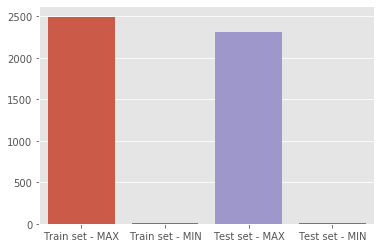

In [4]:
#load dataset as a list
(train_data, train_labels), (test_data, test_labels) = imdb_data

print("train_data ", train_data.shape)
print("train_labels ", train_labels.shape)
print("_"*50)
print("test_data ", test_data.shape)
print("test_labels ", test_labels.shape)
print("_"*50)
print("Minimum value of a word index :", min([min(sequence) for sequence in train_data]))
print("Maximum value of a word index :", max([max(sequence) for sequence in train_data]))
train_len = [len(sequence) for sequence in train_data]
test_len = [len(sequence) for sequence in test_data]
print("Maximum number of words of review in train :", max(train_len))
print("Minimum number of words of review in train :", min(train_len))
print("Maximum number of words of review in test  :", max(test_len))
print("Minimum number of words of review in test  :", min(test_len))

# Visualize the length of max and min length reviews in both training and test sets
sns.barplot(x=['Train set - MAX','Train set - MIN','Test set - MAX','Test set - MIN'], 
            y=[max(train_len),min(train_len),max(test_len),min(test_len)])

### Sentiment Types of Positive and Negative

[0 1]


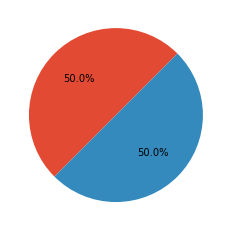

In [5]:
# The unique Sentiments as Target Column
unique, counts = np.unique(np.concatenate((train_labels, test_labels)), return_counts=True)
print(unique)
sentiments = {1: 'Positive', 0: 'Negative'}

# Visualize the Propertion of Positive and Negative Reviewes in the Original Dataset
_ = plt.pie(counts, autopct='%1.1f%%', startangle=45)

### Reverse From Integers to Words Using the Dictinory

In [6]:
def interprete_review(sequence):
    id_to_word = dict([(value, key) for (key, value) in imdb.get_word_index().items()])
    decoded_review = ' '.join([id_to_word.get(idx-3, '?') for idx in sequence])
    print(decoded_review)
    
review_id1 = np.random.choice(train_len)
interprete_review(train_data[review_id1])
print('\nThe sentiment for the above review is:', sentiments.get(train_labels[review_id1]))
print("_"*125)
review_id2 = np.random.choice(test_len)
interprete_review(test_data[review_id2])
print('\nThe sentiment for the above review is:', sentiments.get(test_labels[review_id2]))

? as a another reviewer states ? war is an outstanding film about an outstanding person ? ? ? who would become the jewish joan of ? unfortunately i ? in opinion not ? that miss ? as the lead is too beautiful to be taken seriously as a ? fighter in truth for me her performance is not held back by her beauty but makes it all the more ? in the terror of the sadistic ? as a ? she faces ? ? performance is brave poignant ? or understood and totally believable in other words for me in the zone from the opening credits if you would like to learn about the suffering of someone else for something they believe in and be ? entertained give ? war with ? ? a try my hat is off also to ellen ? as ? mother a much well known and famous actress who could have made effort to walk off with the film in that it is a team effort perhaps of two ? but not an all about eve situation

The sentiment for the above review is: Positive
__________________________________________________________________________________

### Analyze, How much portion of Original Data are Trimming Off by Considering 300 as the Maxlen

In [7]:
maxlen = 1500  #Number of Word used from each Review
# maxlen = max([len(sequence) for sequence in np.concatenate([train_data, test_data])])

#make all sequences of the same length
x_train = pad_sequences(train_data, maxlen=maxlen)
x_test =  pad_sequences(test_data, maxlen=maxlen)

y_train = train_labels
y_test = test_labels

print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)

x_train : (25000, 1500)
x_test  : (25000, 1500)


### Visualize the Random Review After Padding

In [8]:
x_train[np.random.randint(0,len(train_data)-1)]

array([  0,   0,   0, ..., 676, 496,  12])

### Plot the Max Word Count of All the Reviews

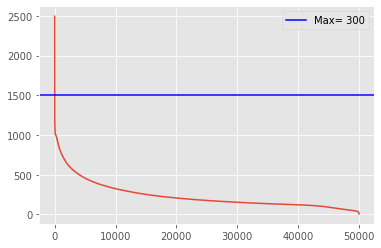

In [9]:
imdb_len = [len(sequence) for sequence in np.concatenate((train_data,test_data))]
plt.plot(np.sort(imdb_len)[::-1])
plt.axhline(maxlen, color='b', label='Max= 300')
plt.legend()

In [10]:
print('Trimming off %.2f%% of data by setting 300 as maxlen' % (len([i for i in imdb_len if i > maxlen]) / len(imdb_len) * 100))

Trimming off 0.02% of data by setting 300 as maxlen


## Build the Keras Sequential Method

### Generic Method to Plot the Validation Curves

In [11]:
def plot_validation_curve(history, metrics):
    plt.clf()
    history_dict = history.history
    f, ax = plt.subplots(1, len(metrics), figsize=(16,6))
    for i, metric in enumerate(metrics):
        metric_values = history_dict[metric]
        val_metric_values = history_dict['val_' + metric]
        epochs = range(1, (len(history_dict[metric]) + 1))
        ax[i].plot(epochs, metric_values, 'bo:', label='Training ' + metric)
        ax[i].plot(epochs, val_metric_values, 'go-', label='Validation ' + metric)
        ax[i].set_title('Training and Validation ' + ('Accuracy' if metric=='acc' else 'Loss'))
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Accuracy' if metric=='acc' else 'Loss')
        ax[i].legend()

### Plot Precision Recall Curve

In [12]:
def plot_prec_recall_vs_thresh(precisions, recalls, thresholds):
    plt.figure(figsize=(10,5))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend()

###  Print the Classification Report

In [13]:
def classification_summary(y_test, y_pred, y_proba):
    print('\033[1mTesting accuracy:\033[0m %.2f%%' % (accuracy_score(y_test, y_pred) * 100))
    print('_'*80)
    print('\033[1mConfusion matrix:\033[0m\n %s' % (confusion_matrix(y_test, y_pred)))
    print('_'*80)
    print('\033[1mClassification report:\033[0m\n %s' % (classification_report(y_test, y_pred)))
    print('_'*80)
    print('\033[1mPrecision-Recall curve\033[10m')
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    plot_prec_recall_vs_thresh(precision, recall, thresholds)

## Artificial Neural Network (ANN)

##### First Deep Learning Model that Going to Develop is a Simple Deep Neural Network

In [14]:
embedding_dim = 300
# Build the network
ann = Sequential()
ann.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
ann.add(Flatten())
ann.add(Dense(1, activation='sigmoid'))
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1500, 300)         1500000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 450000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 450001    
Total params: 1,950,001
Trainable params: 1,950,001
Non-trainable params: 0
_________________________________________________________________


### Train the Model

In [15]:
epochs = 5
batches = 512
start = time()
history = ann.fit(x_train, y_train, epochs=epochs, batch_size=batches, validation_split=0.2)
print('Time spent: %.2f sec' % (time()-start))




Train on 20000 samples, validate on 5000 samples
Epoch 1/5





20000/20000 [==============================] - 252s 13ms/step - loss: 1.1327 - acc: 0.5100 - val_loss: 0.6465 - val_acc: 0.6326
Epoch 2/5
20000/20000 [==============================] - 38s 2ms/step - loss: 0.5128 - acc: 0.7705 - val_loss: 0.3923 - val_acc: 0.8432
Epoch 3/5
20000/20000 [==============================] - 35s 2ms/step - loss: 0.2718 - acc: 0.9028 - val_loss: 0.3016 - val_acc: 0.8776
Epoch 4/5
20000/20000 [==============================] - 35s 2ms/step - loss: 0.1852 - acc: 0.9376 - val_loss: 0.2854 - val_acc: 0.8844
Epoch 5/5
20000/20000 [==============================] - 39s 2ms/step - loss: 0.1311 - acc: 0.9648 - val_loss: 0.2834 - val_acc: 0.8822
Time spent: 403.82 sec


### Validation Accuracy of Loss Curve

<Figure size 432x288 with 0 Axes>

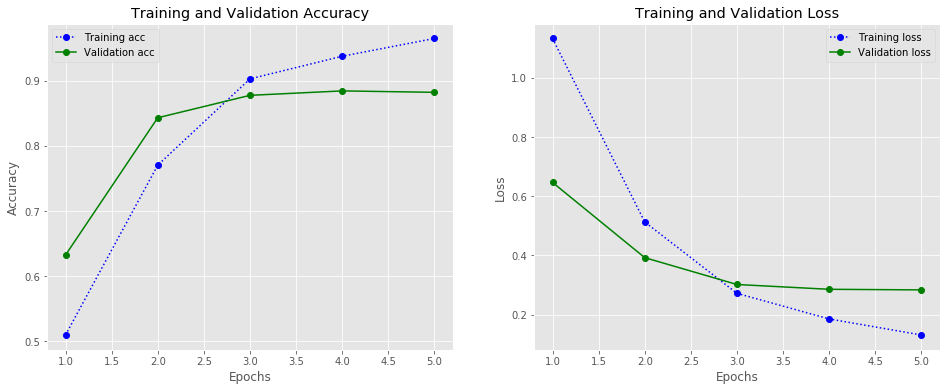

In [16]:
plot_validation_curve(history, ['acc','loss'])

### Finding Loss and Accuracy of Test Set

In [17]:
loss, acc = ann.evaluate(x_test, y_test)
print("Test Loss: %.4f and Accuracy: %.2f%%" % (loss, acc * 100))

25000/25000 [==============================] - 35s 1ms/step
Test Loss: 0.2823 and Accuracy: 88.14%


### Analyze the Classification Summary

Testing accuracy: 88.14%
________________________________________________________________________________
Confusion matrix:
 [[10881  1619]
 [ 1345 11155]]
________________________________________________________________________________
Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88     12500
           1       0.87      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000

________________________________________________________________________________
Precision-Recall curve


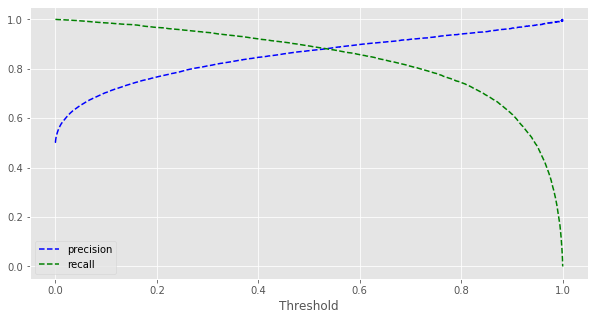

In [18]:
y_pred = ann.predict_classes(x_test)
y_proba = ann.predict_proba(x_test)
classification_summary(y_test, y_pred, y_proba)

## Single Instance Prediction

#### Predict for a Random Pre-Defined Review From IMDB Dataset

In [23]:
review_id = np.random.choice(test_len)
interprete_review(test_data[review_id])
print('\nThe \033[1mACTUAL\033[0m sentiment    :\033[1m' + sentiments.get(test_labels[review_id]) + '\033[0m')
prediction = ann.predict_classes(pad_sequences([test_data[review_id]], maxlen=maxlen))
print('\nThe \033[1mPREDICTED\033[0m sentiment :\033[1m' + sentiments.get(prediction[0][0]) + '\033[0m')

? i just saw this movie at the berlin film ? children's program and it just killed me and pretty much everyone else in the audience and make no mistake about it this film belongs into the all time ? let me tell you that i'm in no way associated with the creators of this film if that's what you come to believe reading this no but this actually is it ? the ? film ? on it ? girl is on almost every account a classic as in ? the story concerns 12 year old ? ? julie who is ? to learn of her ? ? illness special ? in the us would cost 1 5 million and of course nobody could afford that so ? and her friends ? and ? do what every good kid would and ? a bank sounds corny don't forget this is not america and is by no means the tear ? robin williams ? ? ? ? nobody takes seriously anyway director ? set out to make a big budget action comedy for kids and boy did he succeed let me put it this way this film rocks like no kid film and few others did before and there's a whole lot more to it than just the

### Predict for a Custom Review Not Present in the IMDB Dataset

In [24]:
review = '''This Movie should only be watched if you want to punish yourself by sitting through 3 hours of torture.
            Bland movie, extremely slow, boring, monotonous with weak and predictable story with dose of overacting'''
word_dict = imdb.get_word_index()
words = review.split()
review = []
for word in words:
    if word.lower() not in word_dict:
        review.append(2)
    else:
        review.append(word_dict[word.lower()] + 3)

### Generic Method to Print the Name, Size and Output of layer in Keras Model

In [27]:
def layer_outs_for_single_instance(model, instance):
    outputs = [layer.output for layer in model.layers]                  # All Layer Outputs
    function = K.function([model.input, K.learning_phase()], outputs)   # Evaluation Function
    
    if instance.any():
        layer_outs = function([np.array([instance,]), 1.])
        print('_'*75)
        for idx, out in enumerate(layer_outs):
            print('\033[1mLayer# :', idx + 1)
            print('\033[1mName   :', model.layers[idx].name)
            print('\033[1mShape  : ' + str(out.shape) + '\033[0m')
            print(out)
            print('_'*75)

In [29]:
layer_outs_for_single_instance(ann, x_test[np.random.choice(test_len)])


___________________________________________________________________________
Layer# : 1
Name   : embedding_1
Shape  : (1, 1500, 300)
[[[-1.1712558e-02  1.9886037e-03  4.6868948e-03 ...  4.9879684e-05
    1.1913509e-02 -5.3466670e-04]
  [-1.1712558e-02  1.9886037e-03  4.6868948e-03 ...  4.9879684e-05
    1.1913509e-02 -5.3466670e-04]
  [-1.1712558e-02  1.9886037e-03  4.6868948e-03 ...  4.9879684e-05
    1.1913509e-02 -5.3466670e-04]
  ...
  [-1.5485607e-01  8.4687948e-02  4.2227786e-02 ...  1.0890664e-02
   -1.3657656e-01 -1.3122086e-01]
  [ 2.7334269e-02  4.6794999e-02 -5.0126992e-02 ... -3.5805974e-02
    5.4048538e-02  2.6187945e-02]
  [ 1.4696865e-02  2.7763773e-02 -1.3293906e-03 ... -5.2438106e-02
    1.3527225e-03 -2.5414138e-03]]]
___________________________________________________________________________
Layer# : 2
Name   : flatten_1
Shape  : (1, 450000)
[[-0.01171256  0.0019886   0.00468689 ... -0.05243811  0.00135272
  -0.00254141]]
____________________________________________

# OBSERVATIONS:
#### - Importing Libraries
#### - Configure for any default setting of any library
#### - Load the Dataset
#### - Split Train and Test
#### - Sentiment Types of Positive and Negative
#### - Reverse From Integers to Words Using the Dictinory
#### - Analyze, How much portion of Original Data are Trimming Off by Considering 300 as the Maxlen
#### - Visualize the Random Review After Padding
#### - Plot the Max Word Count of All the Reviews
#### - Build the Keras Sequential Method
#### - Generic Method to Plot the Validation Curves
#### - Plot Precision Recall Curve
#### - Print the Classification Report
#### - Artificial Neural Network (ANN)
#### - First Deep Learning Model that Going to Develop is a Simple Deep Neural Network
#### - Train the Model
#### - Validation Accuracy of Loss Curve
#### - Finding Loss and Accuracy of Test Set
#### - Analyze the Classification Summary
#### - Single Instance Prediction
#### - Predict for a Random Pre-Defined Review From IMDB Dataset
#### - Predict for a Custom Review Not Present in the IMDB Dataset
#### - Generic Method to Print the Name, Size and Output of layer in Keras Model

## CONCLUSION:

#### - Predicted Pre-Defined Reviews as Well as For Any Custom Review that is Not in IMDB dataset, even if it is sarcastic. 
#### - Retrive the Output of Each Layer in Keras For a Given Single Test Sample From the Trained Model to Built